In [78]:
import networkx as nx
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

In [79]:
class MongolianTentGraph:
    def __init__(self, n):
        self.n = n
        self.adj = {}
        self.build_graph()

    def __repr__(self):
        return f"MongolianTentGraph(n={self.n}, edges={len(self.compute_edges())})"

    def node_id(self, row, col):
        """Generate a unique node ID for the grid position (row, col)"""
        return row * self.n + col

    def build_graph(self):
        # Build the grid P_3 x P_n
        for row in range(3):
            for col in range(self.n):
                curr = self.node_id(row, col)
                self.adj[curr] = []

                # Connect to right neighbor
                if col + 1 < self.n:
                    self.adj[curr].append(self.node_id(row, col + 1))

                # Connect to bottom neighbor
                if row + 1 < 3:
                    self.adj[curr].append(self.node_id(row + 1, col))

                # Connect left and top neighbors (implicitly)
                if col - 1 >= 0:
                    self.adj[curr].append(self.node_id(row, col - 1))
                if row - 1 >= 0:
                    self.adj[curr].append(self.node_id(row - 1, col))

        # Add the tent peak node and connect to every top-row vertex
        tent_peak = 3 * self.n
        self.adj[tent_peak] = []
        for col in range(0, self.n):
            top_row_node = self.node_id(0, col)
            self.adj[tent_peak].append(top_row_node)
            self.adj[top_row_node].append(tent_peak)

    def compute_edges(self):
        """Convert adjacency list to undirected edge list without duplicates"""
        edges = set()
        for u in self.adj:
            for v in self.adj[u]:
                if u < v:
                    edges.add((u, v))
        return list(edges)

    def max_degree(self):
        return self.n + 1 if self.n < 4 else self.n
    
    def draw(self, labels):
        """Draw the Mongolian Tent graph with given vertex labels"""
        G = nx.Graph()

        # Add nodes and edges
        for u in self.adj:
            G.add_node(u)
            for v in self.adj[u]:
                if u < v:
                    G.add_edge(u, v)

        # Compute positions
        pos = {}
        for row in range(3):
            for col in range(self.n):
                node = self.node_id(row, col)
                pos[node] = (col, -row)
        tent_peak = 3 * self.n
        pos[tent_peak] = ((self.n - 1) / 2, 1)

        # Compute edge labels as sum of vertex labels
        edge_labels = {
            (u, v): labels[u] + labels[v]
            for u, v in G.edges()
        }

        # Draw the graph
        plt.figure(figsize=(1.5 * self.n, 4))
        nx.draw(G, pos, with_labels=True, labels=labels,
                node_color="lightcoral", node_size=900, font_size=10, font_weight="bold")

        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue', font_size=10)

        plt.title(f"Mongolian Tent Graph M₃,{self.n} with Vertex k-Labeling", fontsize=14)
        plt.axis("off")
        plt.show()

In [80]:
n = 3
graph = MongolianTentGraph(n)
graph

MongolianTentGraph(n=3, edges=15)

In [81]:
graph.adj

{0: [1, 3, 9],
 1: [2, 4, 0, 9],
 2: [5, 1, 9],
 3: [4, 6, 0],
 4: [5, 7, 3, 1],
 5: [8, 4, 2],
 6: [7, 3],
 7: [8, 6, 4],
 8: [7, 5],
 9: [0, 1, 2]}

In [82]:
graph.max_degree()

4

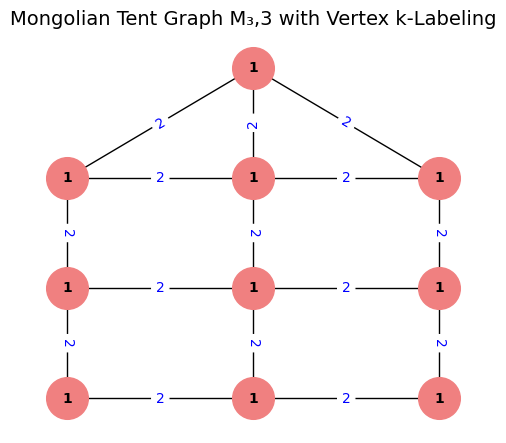

In [83]:
graph.draw(labels={v: 1 for v in graph.adj.keys()})

In [84]:
def label_graph(graph, k):
    vertices = list(graph.adj.keys())
    vertices.sort(key=lambda v: -len(graph.adj[v]))
    max_weight = 2 * k

    def is_valid_labeling(idx, labels, used_weights):
        if idx == len(vertices):
            return True

        v = vertices[idx]
        for label in range(1, k + 1):
            labels[v] = label
            valid = True
            new_weights = []

            for u in graph.adj[v]:
                if u in labels:
                    w = labels[v] + labels[u]
                    if w > max_weight or used_weights[w]:
                        valid = False
                        break
                    new_weights.append(w)

            if valid:
                for w in new_weights:
                    used_weights[w] = True
                if is_valid_labeling(idx + 1, labels, used_weights):
                    return True
                for w in new_weights:
                    used_weights[w] = False

            del labels[v]

        return False

    used_weights = [False] * (max_weight + 1)
    labels = {}
    success = is_valid_labeling(0, labels, used_weights)
    return success, labels if success else None


def find_edge_irregularity_strength(graph):
    """Find minimal k where valid vertex k-labeling gives unique edge weights"""
    edge_count = 6 * graph.n - 3
    delta = graph.max_degree()
    lower = math.ceil((edge_count + 1) / 2)
    if not "MongolianTentGraph" == str(type(graph)).split('.')[-1].split("'")[0]:
        lower = max(lower, delta)
        edge_count = len(graph.compute_edges())

    upper = 2 * edge_count
    print(f"Edge count: {edge_count}, Lower bound for k: {lower}, Upper bound for k: {upper}")
    pbar = tqdm(total=upper - lower + 1, desc="Searching k")

    while lower < upper:
        mid = (lower + upper) // 2
        pbar.set_postfix({"k": mid})
        success, labels = label_graph(graph, mid)
        if success:
            upper = mid
        else:
            lower = mid + 1
        pbar.update(1)

    pbar.close()
    return lower, labels

Edge count: 15, Lower bound for k: 8, Upper bound for k: 30


Searching k:  22%|██▏       | 5/23 [00:00<00:00, 925.98it/s, k=8]  

Edge irregularity strength es(G): 8


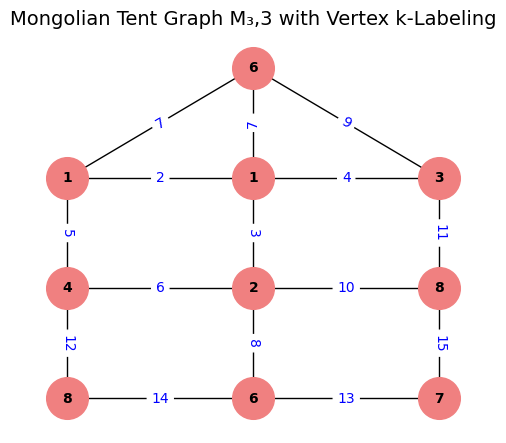

In [85]:
es, labels = find_edge_irregularity_strength(graph)
print(f"Edge irregularity strength es(G): {es}")
graph.draw(labels=labels)